See also:
* [GML Spec](https://fffff.at/gml/)
* [javascript canvas player example](https://jamiedubs.com/canvasplayer/?random), and [source](https://github.com/jamiew/canvasplayer)

In [1]:
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
FOLDER = Path('data/gml')
file = FOLDER / '68000.json'

In [31]:
def filter_by_application(fname):
    with open(fname, 'r') as f:
        return json.load(f).get('gml_application') == 'Fat Tag - Katsu Edition'
def read_json(fname):
    with open(fname, 'r') as file:
        return json.load(file, object_hook=json_katsu_decoder_hook)
def json_katsu_decoder_hook(data):
    if 'time' in data:
        try:
            return float(data['time']), float(data['x']), float(data['y']), float(data['z'])
        except KeyError:
            pass
    elif 'pt' in data:
        return np.array(data['pt']).reshape(-1, 4)  # reshape due to GML-json conversion bug
    elif 'stroke' in data:
        return [data['stroke']] if isinstance(data['stroke'], np.ndarray) else data['stroke']
    if 'tag' in data:
        # scale canvas to screen size
        w = float(data['tag']['environment']['screenBounds']['x'])
        h = float(data['tag']['environment']['screenBounds']['y'])
        for stroke in data['tag']['drawing']:
            stroke[:, 1] *= w
            stroke[:, 2] *= h
        # swap x and y if the device is held in portrait mode
        orientation = data['tag']['environment']['up']
        if float(orientation['x']):
            for stroke in data['tag']['drawing']:
                stroke[:, [1, 2]] = stroke[:, [2, 1]]
        elif float(orientation['y']):
            for stroke in data['tag']['drawing']:
                stroke[:, 2] = w - stroke[:, 2]
    return data

sorted_fnames = reversed(sorted(FOLDER.glob('*.json'), key=lambda x: int(x.with_suffix('').name)))
katsu_fnames = filter(filter_by_application, sorted_fnames)
jsons = map(read_json, katsu_fnames)

display(next(jsons))

{'id': 69815,
 'created_at': '2022-12-28T22:28:23.000Z',
 'updated_at': '2022-12-28T22:28:23.000Z',
 'image_file_name': 'upload.jpg',
 'image_content_type': 'image/jpeg',
 'image_file_size': 803144,
 'image_updated_at': '2022-12-28T22:28:22.000Z',
 'gml_application': 'Fat Tag - Katsu Edition',
 'gml_username': 'FatTag',
 'gml_uniquekey': '7FD9E26C-99C6-478D-A88C-E3A0C794F59C',
 'gml_uniquekey_hash': 'e4d9ffb459cef70e3c8581ab8ca4e54de4064756',
 'gml_keywords': 'fattag',
 'gml': {'spec': '0.1b',
  'tag': {'header': {'client': {'name': 'Fat Tag - Katsu Edition',
     'version': '1.0',
     'username': 'FatTag',
     'keywords': 'fattag',
     'uniqueKey': '7FD9E26C-99C6-478D-A88C-E3A0C794F59C'}},
   'environment': {'up': {'x': '0', 'y': '1', 'z': '0'},
    'screenBounds': {'x': '2436', 'y': '1125', 'z': '18.000000000'}},
   'drawing': [array([[0.00000000e+00, 7.73370489e+01, 2.09753845e+03, 0.00000000e+00],
           [4.87976070e-02, 6.57191778e+01, 2.07253848e+03, 0.00000000e+00],
     

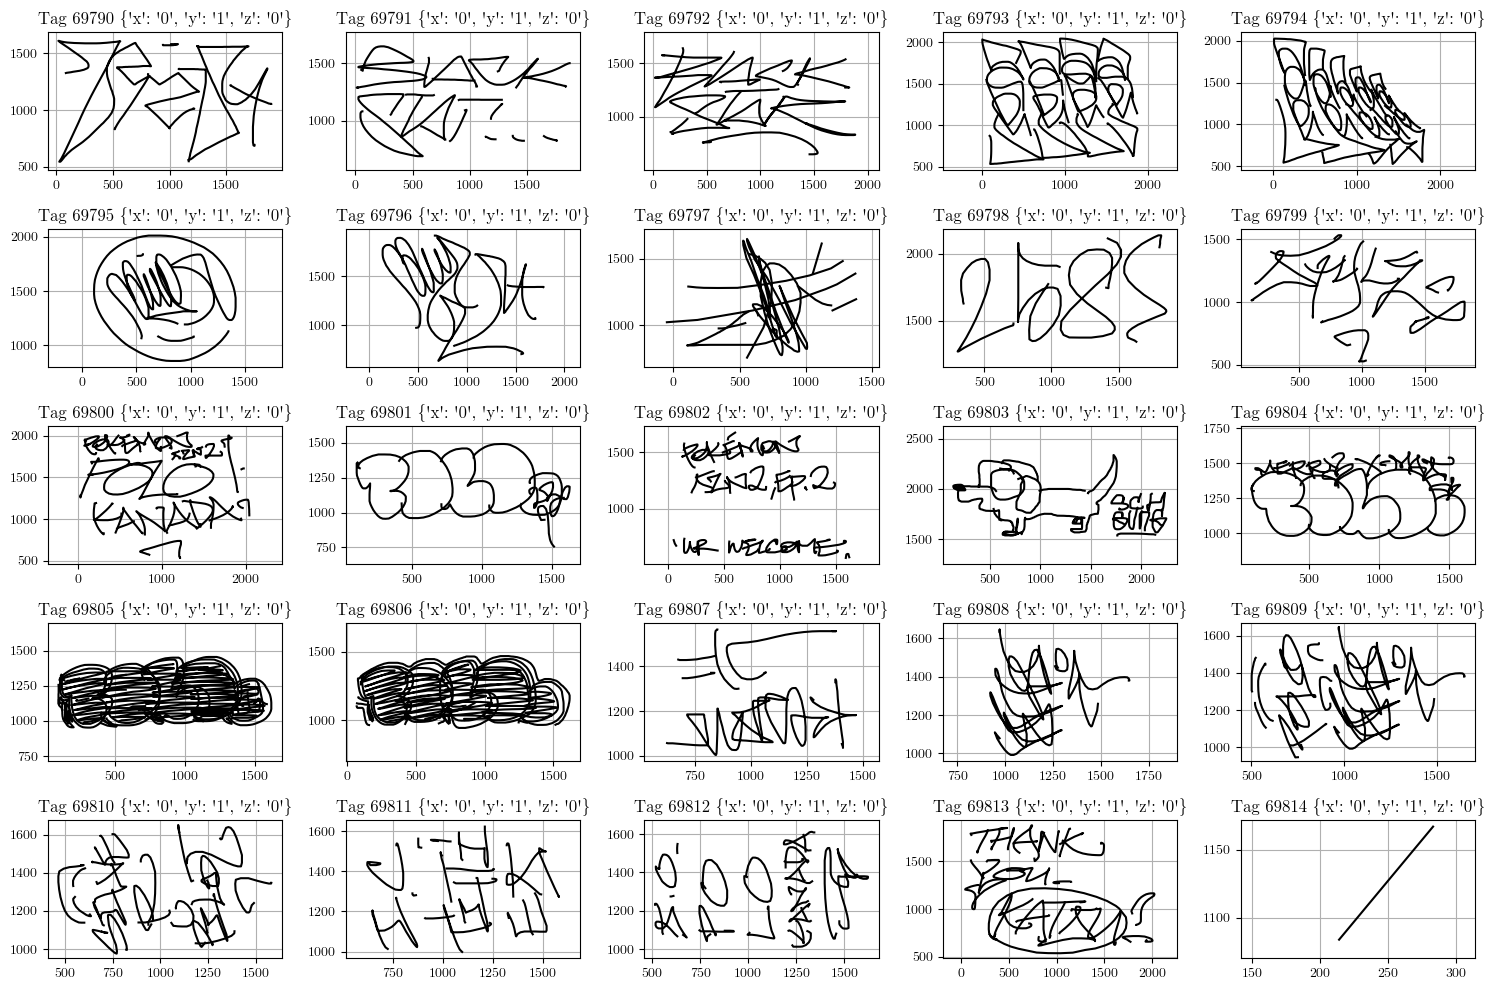

In [32]:
def draw_tag(ax, data):
    for stroke in data['gml']['tag']['drawing']:
        ax.plot(stroke[:, 1], stroke[:, 2], 'k-')
        ax.axis('equal')
    ax.set_title(f"Tag {data['id']} {data['gml']['tag']['environment']['up']}")
fig, axes = plt.subplots(5, 5, figsize=(15, 10))
for data, ax in zip(jsons, reversed(axes.flatten())):
    draw_tag(ax, data)
fig.tight_layout()